# Human-in-the-Loop Machine Learning: Final Project Majority Voting and Dawid-Skene

### Imports

In [1]:
# imports
import datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from data_utils import get_majority_vote, get_ds_format
from data_info import comment_annotations, both_demographic_axes
from dawid_skene import run
from comment_annotator_ids import filtered_comment_annotator_id

### 1. Data loading and preparation

In [2]:
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'default') 
filtered_dataset = dataset.filter(lambda instance: (instance['comment_id'], instance['annotator_id']) in filtered_comment_annotator_id)

comment_id_to_data = {}
for instance in filtered_dataset['train']:
    if instance['comment_id'] not in comment_id_to_data.keys():
        comment_id_to_data[instance['comment_id']] = {'comment': instance['text']}
        for axis in comment_annotations:
            comment_id_to_data[instance['comment_id']][axis] = []
    for axis in comment_annotations:
            comment_id_to_data[instance['comment_id']][axis].append(instance[axis])

### 2. Majority Voting

In [27]:
# get data in axes format
axes_results = {}
for axis in comment_annotations:
    axes_results[axis] = []

# run majority voting
for id in comment_id_to_data:
    results = get_majority_vote(comment_id_to_data[id])
    for axis in comment_annotations:
        axes_results[axis].append(results[axis])

(array([33.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([0.    , 0.1333, 0.2667, 0.4   , 0.5333, 0.6667, 0.8   , 0.9333,
        1.0667, 1.2   , 1.3333, 1.4667, 1.6   , 1.7333, 1.8667, 2.    ,
        2.1333, 2.2667, 2.4   , 2.5333, 2.6667, 2.8   , 2.9333, 3.0667,
        3.2   , 3.3333, 3.4667, 3.6   , 3.7333, 3.8667, 4.    ]),
 <BarContainer object of 30 artists>)

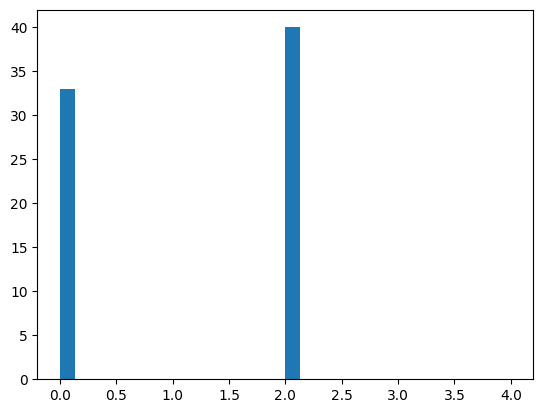

In [28]:
plt.hist(axes_results['hatespeech'], bins=30, range=[0, 4])

### 3. Dawid-Skene

In [29]:
# format data for dawid-skene code
ds_format_data = {}
for axis in comment_annotations:
    ds_format_data[axis] = get_ds_format(filtered_dataset['train'], axis)

# run dawid-skene
dawid_skene_results = {}
for axis in comment_annotations:
    dawid_skene_results[axis] = run(ds_format_data[axis])

# get argmax for each comment
ds_axes_results = {}
for axis in comment_annotations:
    ds_axes_results[axis] = [np.argmax(v) for k, v in dawid_skene_results[axis].items()]

/Users/miriam/Desktop/hitlml-project/dawid_skene.py:228: RuntimeWarning: overflow encountered in divide
  error_rates[k,j,:] = error_rates[k,j,:]/float(sum_over_responses)


(array([31.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 35.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([0.    , 0.1333, 0.2667, 0.4   , 0.5333, 0.6667, 0.8   , 0.9333,
        1.0667, 1.2   , 1.3333, 1.4667, 1.6   , 1.7333, 1.8667, 2.    ,
        2.1333, 2.2667, 2.4   , 2.5333, 2.6667, 2.8   , 2.9333, 3.0667,
        3.2   , 3.3333, 3.4667, 3.6   , 3.7333, 3.8667, 4.    ]),
 <BarContainer object of 30 artists>)

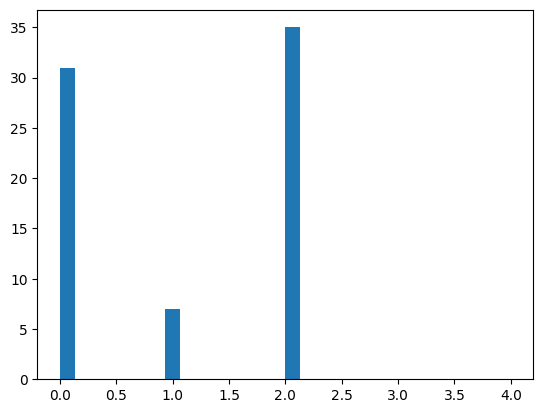

In [30]:
plt.hist(ds_axes_results['hatespeech'], bins=30,  range=[0, 4])

### 4. Figures for Majority-Voting vs Dawid-Skene

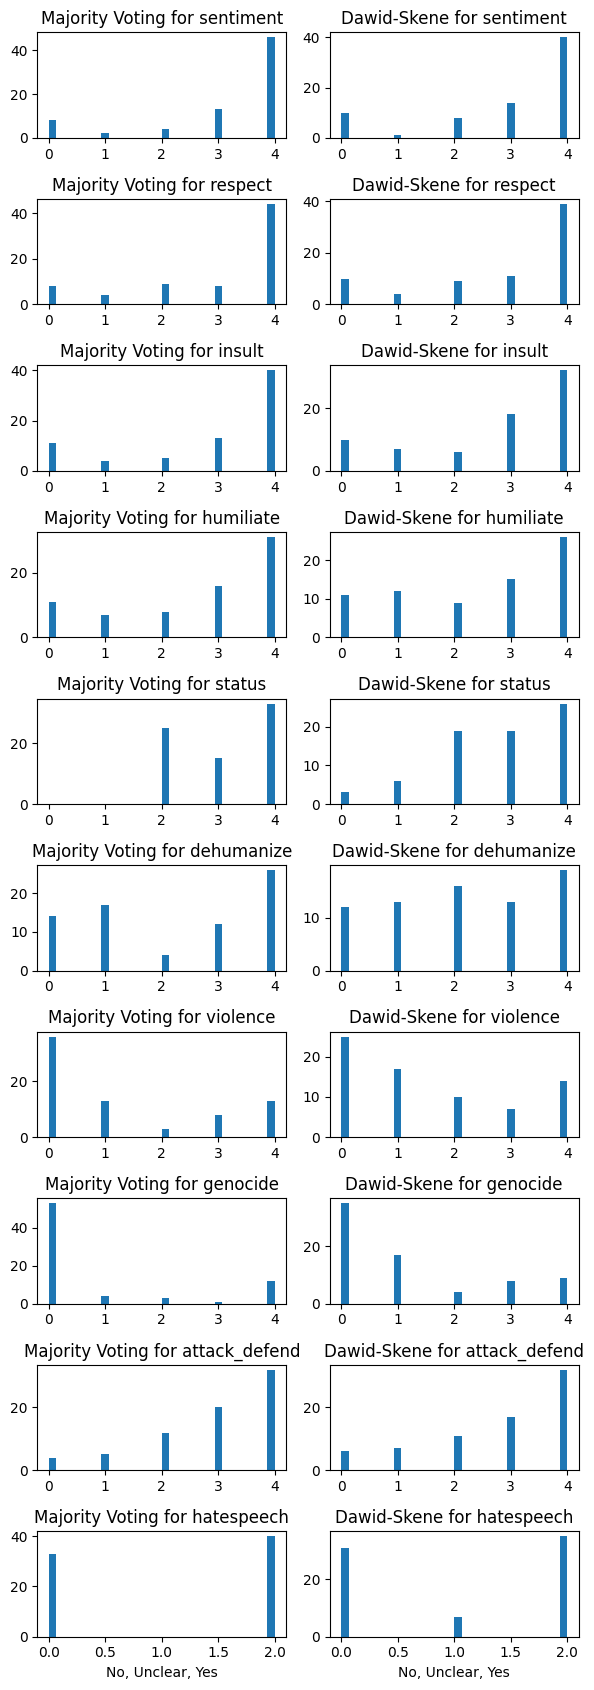

In [33]:
# Generate some random data for demonstration

# Set up the figure with a grid layout (3 rows, 4 columns)
fig, axes = plt.subplots(10, 2, figsize=(6, 17))

# Flatten the 2D array of axes for easier iteration
axes = axes.ravel()

# Create histograms in each subplot
i = 0
for axis in comment_annotations:
    if axis == 'hatespeech':
        # majority voting graph
        axes[i].hist(axes_results[axis], bins=30, range=[0, 2])
        axes[i].set_title('Majority Voting for ' + axis)
        axes[i].set_xlabel('No, Unclear, Yes')
        # axes[i].set_ylabel('Frequency')
        i += 1
        # Dawid-Skene graph
        axes[i].hist(ds_axes_results[axis], bins=30, range=[0, 2])
        axes[i].set_title('Dawid-Skene for ' + axis)
        axes[i].set_xlabel('No, Unclear, Yes')
        # axes[i].set_ylabel('Frequency')
        i += 1
    else:
        # majority voting graph
        axes[i].hist(axes_results[axis], bins=30, range=[0, 4])
        axes[i].set_title('Majority Voting for ' + axis)
        # axes[i].set_xlabel('Value')
        # axes[i].set_ylabel('Frequency')
        i += 1
        # Dawid-Skene graph
        axes[i].hist(ds_axes_results[axis], bins=30, range=[0, 4])
        axes[i].set_title('Dawid-Skene for ' + axis)
        # axes[i].set_xlabel('Value')
        # axes[i].set_ylabel('Frequency')
        i += 1

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.savefig("figures/maj_vote_d_s.pdf")

### 5. Filtering in- and out- of target data

In [6]:
in_target_data = []
out_of_target_data = []

for instance in filtered_dataset['train']:
    in_target = False
    for axis in both_demographic_axes.keys():
        for option in both_demographic_axes[axis]:
            annotator_query = "annotator" + "_" + axis + "_" + option
            comment_query = "target" + "_" + axis + "_" + option
            if instance[annotator_query] == True and instance[comment_query] == True:
                in_target = True
    if in_target == True:
        in_target_data.append(instance)
    else:
        out_of_target_data.append(instance)
# this leaves us with 179 in target and 606 out of target points

### 6. Majority vote for in-target annotators

In [7]:
comment_id_to_data_all = {}
print("getting in correct format")
for instance in tqdm(in_target_data):
    if instance['comment_id'] not in comment_id_to_data_all.keys():
        comment_id_to_data_all[instance['comment_id']] = {'comment': instance['text']}
        for axis in comment_annotations:
            comment_id_to_data_all[instance['comment_id']][axis] = []
    for axis in comment_annotations:
            comment_id_to_data_all[instance['comment_id']][axis].append(instance[axis])

# get data in axes format
print("getting in axes format")
axes_results_all = {}
for axis in tqdm(comment_annotations):
    axes_results_all[axis] = []

# run majority voting
print("calculate majority voting")
for id in tqdm(comment_id_to_data_all):
    results = get_majority_vote(comment_id_to_data_all[id])
    for axis in comment_annotations:
        axes_results_all[axis].append(results[axis])

getting in correct format


100%|██████████| 179/179 [00:00<00:00, 136629.74it/s]


getting in axes format


100%|██████████| 10/10 [00:00<00:00, 178481.02it/s]


calculate majority voting


100%|██████████| 49/49 [00:00<00:00, 75365.20it/s]


(array([19.,  0.,  0.,  0.,  0.,  0.,  0., 15.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,
         0.,  0.,  0.,  7.]),
 array([0.        , 0.13333333, 0.26666667, 0.4       , 0.53333333,
        0.66666667, 0.8       , 0.93333333, 1.06666667, 1.2       ,
        1.33333333, 1.46666667, 1.6       , 1.73333333, 1.86666667,
        2.        , 2.13333333, 2.26666667, 2.4       , 2.53333333,
        2.66666667, 2.8       , 2.93333333, 3.06666667, 3.2       ,
        3.33333333, 3.46666667, 3.6       , 3.73333333, 3.86666667,
        4.        ]),
 <BarContainer object of 30 artists>)

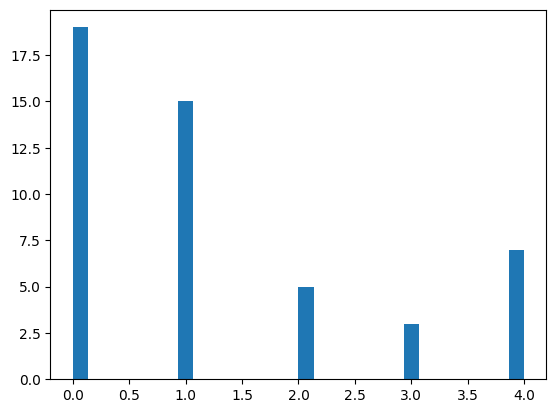

In [8]:
plt.hist(axes_results_all['violence'], bins=30, range=[0, 4])

### 7. Dawid-Skene for in-target annotators

In [9]:
# format data for dawid-skene code
print("formatting data")
ds_format_data_all = {}
for axis in tqdm(comment_annotations):
    ds_format_data_all[axis] = get_ds_format(in_target_data, axis)

# run dawid-skene
print("running dawid-skene")
dawid_skene_results_all = {}
for axis in tqdm(comment_annotations):
    dawid_skene_results_all[axis] = run(ds_format_data_all[axis])

# get argmax for each comment
print("getting consensus from dawid-skene")
ds_axes_results_all = {}
for axis in tqdm(comment_annotations):
    ds_axes_results_all[axis] = [np.argmax(v) for k, v in dawid_skene_results_all[axis].items()]

formatting data


100%|██████████| 10/10 [00:00<00:00, 5783.65it/s]


running dawid-skene


 20%|██        | 2/10 [00:00<00:03,  2.34it/s]/Users/miriam/Desktop/hitlml-project/dawid_skene.py:228: RuntimeWarning: overflow encountered in divide
  error_rates[k,j,:] = error_rates[k,j,:]/float(sum_over_responses)
100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


getting consensus from dawid-skene


100%|██████████| 10/10 [00:00<00:00, 9569.48it/s]


(array([24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 25.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([0.    , 0.1333, 0.2667, 0.4   , 0.5333, 0.6667, 0.8   , 0.9333,
        1.0667, 1.2   , 1.3333, 1.4667, 1.6   , 1.7333, 1.8667, 2.    ,
        2.1333, 2.2667, 2.4   , 2.5333, 2.6667, 2.8   , 2.9333, 3.0667,
        3.2   , 3.3333, 3.4667, 3.6   , 3.7333, 3.8667, 4.    ]),
 <BarContainer object of 30 artists>)

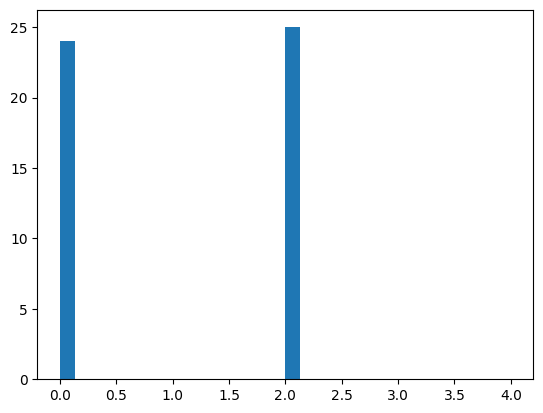

In [10]:
plt.hist(ds_axes_results_all['hatespeech'], bins=30,  range=[0, 4])

### 6. Plotting in-target_annotators

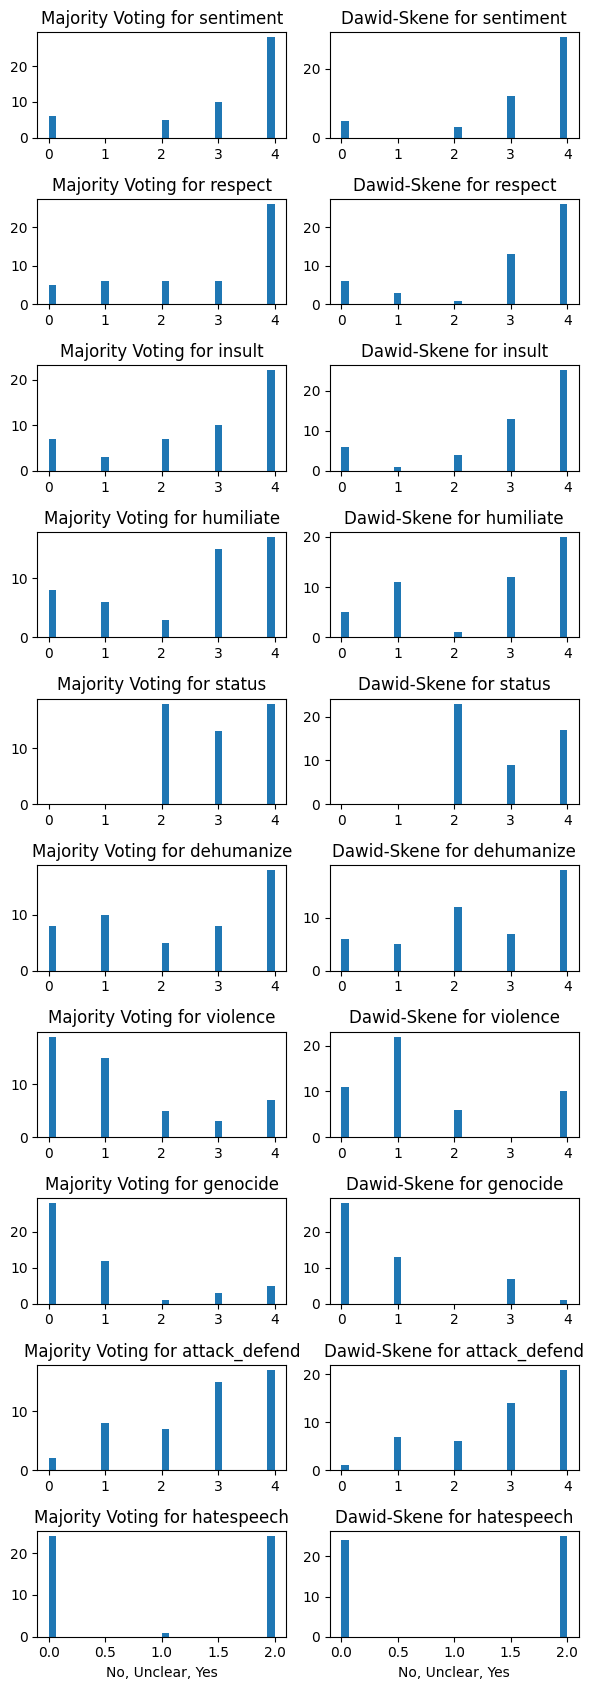

In [11]:
# Generate some random data for demonstration

# Set up the figure with a grid layout (3 rows, 4 columns)
fig, axes = plt.subplots(10, 2, figsize=(6, 17))

# Flatten the 2D array of axes for easier iteration
axes = axes.ravel()

# Create histograms in each subplot
i = 0
for axis in comment_annotations:
    if axis == 'hatespeech':
        # majority voting graph
        axes[i].hist(axes_results_all[axis], bins=30, range=[0, 2])
        axes[i].set_title('Majority Voting for ' + axis)
        axes[i].set_xlabel('No, Unclear, Yes')
        # axes[i].set_ylabel('Frequency')
        i += 1
        # Dawid-Skene graph
        axes[i].hist(ds_axes_results_all[axis], bins=30, range=[0, 2])
        axes[i].set_title('Dawid-Skene for ' + axis)
        axes[i].set_xlabel('No, Unclear, Yes')
        # axes[i].set_ylabel('Frequency')
        i += 1
    else:
        # majority voting graph
        axes[i].hist(axes_results_all[axis], bins=30, range=[0, 4])
        axes[i].set_title('Majority Voting for ' + axis)
        # axes[i].set_xlabel('Value')
        # axes[i].set_ylabel('Frequency')
        i += 1
        # Dawid-Skene graph
        axes[i].hist(ds_axes_results_all[axis], bins=30, range=[0, 4])
        axes[i].set_title('Dawid-Skene for ' + axis)
        # axes[i].set_xlabel('Value')
        # axes[i].set_ylabel('Frequency')
        i += 1

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.savefig("figures/maj_vote_d_s_in_target.pdf")

### 7. Majority voting for out-of-target annotators

In [12]:
comment_id_to_data_all = {}
print("getting in correct format")
for instance in tqdm(out_of_target_data):
    if instance['comment_id'] not in comment_id_to_data_all.keys():
        comment_id_to_data_all[instance['comment_id']] = {'comment': instance['text']}
        for axis in comment_annotations:
            comment_id_to_data_all[instance['comment_id']][axis] = []
    for axis in comment_annotations:
            comment_id_to_data_all[instance['comment_id']][axis].append(instance[axis])

# get data in axes format
print("getting in axes format")
axes_results_all = {}
for axis in tqdm(comment_annotations):
    axes_results_all[axis] = []

# run majority voting
print("calculate majority voting")
for id in tqdm(comment_id_to_data_all):
    results = get_majority_vote(comment_id_to_data_all[id])
    for axis in comment_annotations:
        axes_results_all[axis].append(results[axis])

getting in correct format


100%|██████████| 606/606 [00:00<00:00, 679430.16it/s]


getting in axes format


100%|██████████| 10/10 [00:00<00:00, 55553.70it/s]


calculate majority voting


100%|██████████| 73/73 [00:00<00:00, 89895.53it/s]


(array([39.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,
         0.,  0.,  0., 15.]),
 array([0.    , 0.1333, 0.2667, 0.4   , 0.5333, 0.6667, 0.8   , 0.9333,
        1.0667, 1.2   , 1.3333, 1.4667, 1.6   , 1.7333, 1.8667, 2.    ,
        2.1333, 2.2667, 2.4   , 2.5333, 2.6667, 2.8   , 2.9333, 3.0667,
        3.2   , 3.3333, 3.4667, 3.6   , 3.7333, 3.8667, 4.    ]),
 <BarContainer object of 30 artists>)

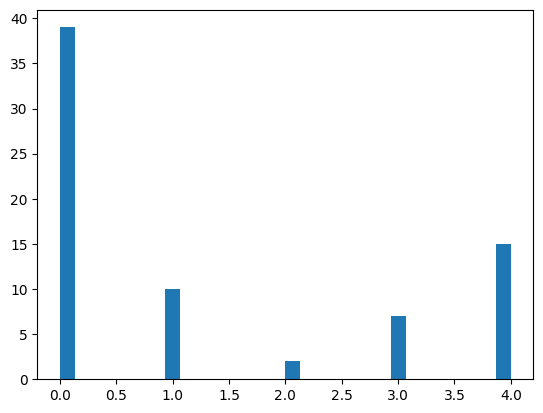

In [13]:
plt.hist(axes_results_all['violence'], bins=30, range=[0, 4])

### 8. Dawid-skene for out-of-target annotators

In [14]:
# format data for dawid-skene code
print("formatting data")
ds_format_data_all = {}
for axis in tqdm(comment_annotations):
    ds_format_data_all[axis] = get_ds_format(out_of_target_data, axis)

# run dawid-skene
print("running dawid-skene")
dawid_skene_results_all = {}
for axis in tqdm(comment_annotations):
    dawid_skene_results_all[axis] = run(ds_format_data_all[axis])

# get argmax for each comment
print("getting consensus from dawid-skene")
ds_axes_results_all = {}
for axis in tqdm(comment_annotations):
    ds_axes_results_all[axis] = [np.argmax(v) for k, v in dawid_skene_results_all[axis].items()]

formatting data


100%|██████████| 10/10 [00:00<00:00, 3749.94it/s]


running dawid-skene


  0%|          | 0/10 [00:00<?, ?it/s]/Users/miriam/Desktop/hitlml-project/dawid_skene.py:228: RuntimeWarning: overflow encountered in divide
  error_rates[k,j,:] = error_rates[k,j,:]/float(sum_over_responses)
100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


getting consensus from dawid-skene


100%|██████████| 10/10 [00:00<00:00, 4627.94it/s]


(array([34.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 33.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([0.    , 0.1333, 0.2667, 0.4   , 0.5333, 0.6667, 0.8   , 0.9333,
        1.0667, 1.2   , 1.3333, 1.4667, 1.6   , 1.7333, 1.8667, 2.    ,
        2.1333, 2.2667, 2.4   , 2.5333, 2.6667, 2.8   , 2.9333, 3.0667,
        3.2   , 3.3333, 3.4667, 3.6   , 3.7333, 3.8667, 4.    ]),
 <BarContainer object of 30 artists>)

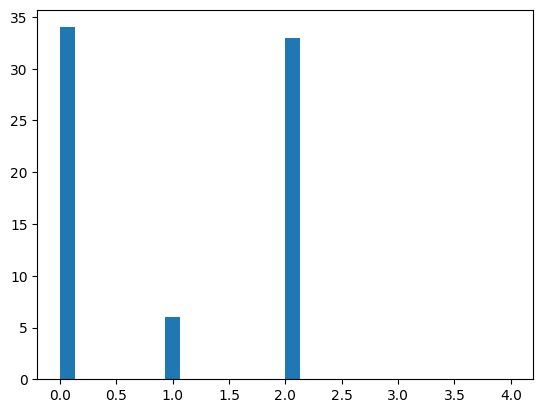

In [15]:
plt.hist(ds_axes_results_all['hatespeech'], bins=30,  range=[0, 4])

### 9. Plotting out-of-target annotators

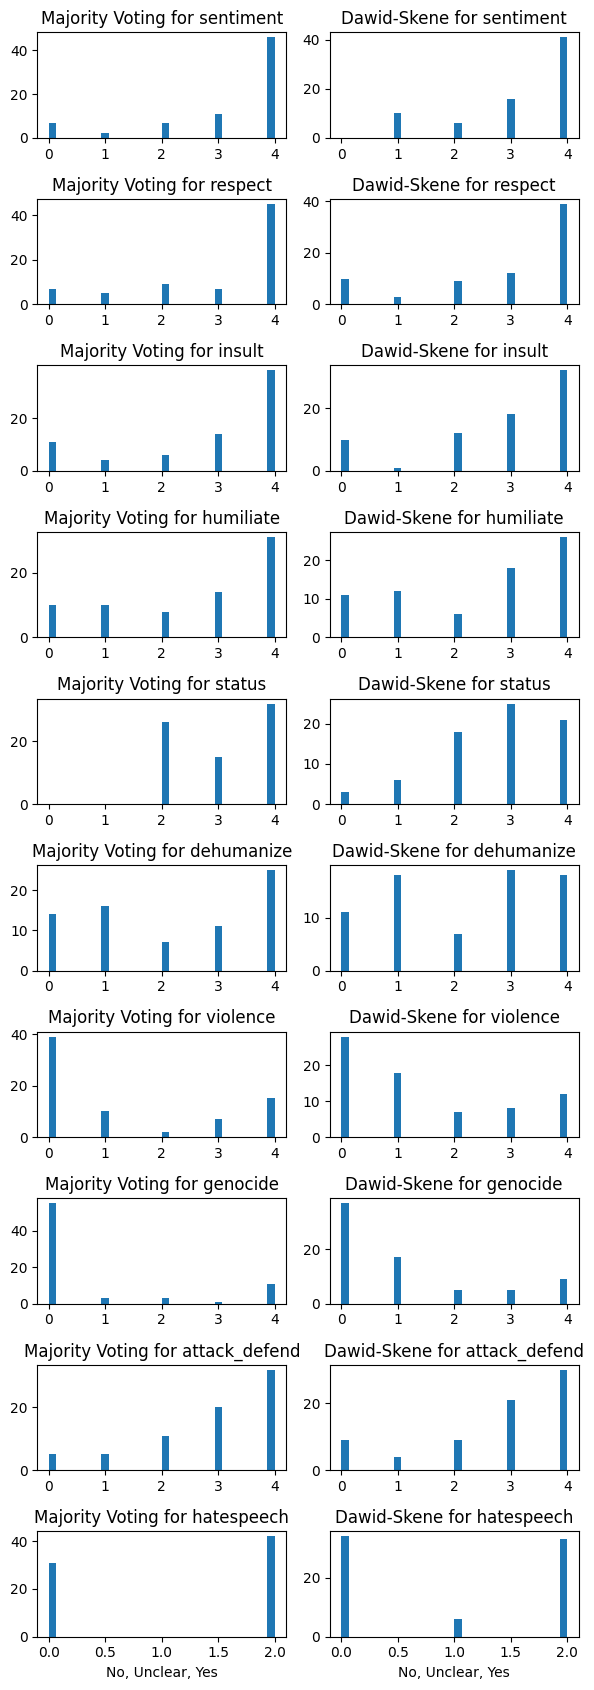

In [16]:
# Generate some random data for demonstration

# Set up the figure with a grid layout (3 rows, 4 columns)
fig, axes = plt.subplots(10, 2, figsize=(6, 17))

# Flatten the 2D array of axes for easier iteration
axes = axes.ravel()

# Create histograms in each subplot
i = 0
for axis in comment_annotations:
    if axis == 'hatespeech':
        # majority voting graph
        axes[i].hist(axes_results_all[axis], bins=30, range=[0, 2])
        axes[i].set_title('Majority Voting for ' + axis)
        axes[i].set_xlabel('No, Unclear, Yes')
        # axes[i].set_ylabel('Frequency')
        i += 1
        # Dawid-Skene graph
        axes[i].hist(ds_axes_results_all[axis], bins=30, range=[0, 2])
        axes[i].set_title('Dawid-Skene for ' + axis)
        axes[i].set_xlabel('No, Unclear, Yes')
        # axes[i].set_ylabel('Frequency')
        i += 1
    else:
        # majority voting graph
        axes[i].hist(axes_results_all[axis], bins=30, range=[0, 4])
        axes[i].set_title('Majority Voting for ' + axis)
        # axes[i].set_xlabel('Value')
        # axes[i].set_ylabel('Frequency')
        i += 1
        # Dawid-Skene graph
        axes[i].hist(ds_axes_results_all[axis], bins=30, range=[0, 4])
        axes[i].set_title('Dawid-Skene for ' + axis)
        # axes[i].set_xlabel('Value')
        # axes[i].set_ylabel('Frequency')
        i += 1

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.savefig("figures/maj_vote_d_s_out_of_target.pdf")